In [26]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum
from ase.optimize import LBFGS, BFGS
from ase import Atom

from ase.io.trajectory import Trajectory
from ase.md import Langevin, Bussi
from ase import io

from mace.calculators import mace_mp
macemp_FT = mace_mp(dispersion=True, default_dtype="float64", model="FT_models/MACE_medium_newE0s_revPBE_D3_300.model")


Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [399]:
plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 16,              
    "axes.labelsize": 16,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 14,        
    "ytick.labelsize": 14,       
    "legend.fontsize": 14,      
    "text.usetex": True       
})

In [4]:
caco3_frame = io.read("caco3-water/revPBE-D3/gen2.xyz", index="1")

In [27]:
io.write("CaCO3_frame.xyz", caco3_frame)

In [120]:
caco3_frame = io.read("CaCO3_frame.xyz")

In [448]:
view(caco3_frame)

<Popen: returncode: None args: ['/Users/joehart/Desktop/0_Cambridge/0_MPhil_...>

2025-03-15 15:41:20.722 Python[64804:109837264] +[IMKClient subclass]: chose IMKClient_Legacy
2025-03-15 15:41:20.722 Python[64804:109837264] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [453]:
view(caco3_frame, viewer="x3d")

In [454]:
view(caco3_frame)

<Popen: returncode: None args: ['/Users/joehart/Desktop/0_Cambridge/0_MPhil_...>

2025-03-15 15:49:45.414 Python[65274:109845071] +[IMKClient subclass]: chose IMKClient_Legacy
2025-03-15 15:49:45.414 Python[65274:109845071] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/ase/visualize/viewers.py", line 265, in <module>
    cli_main()
  File "/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/ase/visualize/viewers.py", line 261, in cli_main
    cli_viewer.view_blocking(atoms, data)
  File "/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/ase/visualize/viewers.

In [17]:
caco3_frame.cell

Cell([14.081269264221191, 14.081269264221191, 14.081269264221191])

In [19]:
(len(caco3_frame) - 5) / 3

98.0

In [ ]:
62 * 18 /((12.41*1e-8)**3 * 6.022e23) # desnity of water in paper in g/cm^3

0.9696345880846504

In [97]:
water_density_caco3 = 98 * 18 /((caco3_frame.cell[0][0]*1e-8)**3 * 6.022e23)
water_density_caco3

1.04913752270322

In [ ]:
caco3_frame

### Matching reference cell and water density

In [160]:
caco3_frame_copy = caco3_frame.copy()
scaling_factor = 12.41 / caco3_frame_copy.cell[0][0]
caco3_frame_copy.set_cell(caco3_frame_copy.cell * scaling_factor, scale_atoms=True)


water_density_caco3 = 98 * 18.1 /((caco3_frame_copy.cell[0][0]*1e-8)**3 * 6.022e23)

density_ratio = 0.97 / water_density_caco3  # Target / Current density

water_indices = []
for i, atom in enumerate(caco3_frame_copy):
    if atom.symbol == "O":  # Oxygen in water
        neighbors = [n.index for n in caco3_frame_copy if n.symbol == "H" and caco3_frame_copy.get_distance(i, n.index) < 1.2]
        if len(neighbors) == 2:
            water_indices.append([i] + neighbors)  # Store water molecule as [O, H, H]

water_indices = np.array(water_indices)

# Determine how many water molecules to keep
num_water_to_keep = 62

# Shuffle and select water molecules to keep
np.random.shuffle(water_indices)
keep_water_indices = water_indices[:num_water_to_keep].flatten()

# Create a new atoms object keeping CaCO3 intact and selecting fewer water molecules
keep_indices = np.setdiff1d(np.arange(len(caco3_frame_copy)), water_indices.flatten())  # Keep non-water atoms
keep_indices = np.concatenate((keep_indices, keep_water_indices))  # Add selected water molecules

# Construct the new atoms object
new_atoms = caco3_frame_copy[keep_indices]

# Save the modified structure
io.write("CaCO3_frame_modified.xyz", new_atoms)


print(f"new water density = {num_water_to_keep * 18 /((caco3_frame_copy.cell[0][0]*1e-8)**3 * 6.022e23)}")



new water density = 0.9696345880846504


In [161]:
CaCO3_frame_modified = io.read("CaCO3_frame_modified.xyz")

In [163]:
CaCO3_frame_modified.get_volume()

1911.2405209999986

In [166]:
CaCO3_frame_modified.cell, 62 * 18 / ((CaCO3_frame_modified.cell[0][0]*1e-8)**3 * 6.022e23)

(Cell([12.41, 12.41, 12.41]), 0.9696345880846504)

In [162]:
view(CaCO3_frame_modified, viewer='x3d')

In [122]:
3*120

360

### MD setup

In [ ]:

def remove_COM_velocity(atoms):
    momenta = atoms.get_momenta()
    total_momentum = momenta.sum(axis=0)
    total_mass = atoms.get_masses().sum()
    com_velocity = total_momentum / total_mass
    atoms.set_momenta(momenta - com_velocity * atoms.get_masses()[:, np.newaxis])




In [84]:

import time
start_time = time.time()

def printenergy(a=caco3_frame):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    elapsed_time = time.time() - start_time  # Time in seconds
    elapsed_min, elapsed_sec = divmod(elapsed_time, 60)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV Time Elapsed: %dm %.1fs' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin, int(elapsed_min), int(elapsed_sec)))


caco3_frame.calc = macemp_FT
T_init = 300  # Initial temperature in K
MaxwellBoltzmannDistribution(caco3_frame, temperature_K=T_init)
remove_COM_velocity(caco3_frame)

#dyn = Langevin(m_g_relaxed, 1 * units.fs, T_init * units.kB, 0.01)
dyn = Bussi(caco3_frame, 1 * units.fs, T_init, 0.01)
#n_steps = 5000 + 20000 # 5ps pre-equilibration + 20ps production
n_steps = 10

dyn.attach(printenergy, interval = 10)
#dyn.attach(lambda: remove_COM_momentum(m_g_relaxed), interval=10)

traj = Trajectory('caco3_traj/CaCO3_FT_100.traj', 'w', caco3_frame)
dyn.attach(traj.write, interval = 10)
printenergy()
dyn.run(n_steps)

Energy per atom: Epot = -162.215eV  Ekin = 0.042eV (T=324K)  Etot = -162.173eV Time Elapsed: 0m 6.0s
Energy per atom: Epot = -162.215eV  Ekin = 0.042eV (T=324K)  Etot = -162.173eV Time Elapsed: 0m 7.0s
Energy per atom: Epot = -162.209eV  Ekin = 0.038eV (T=291K)  Etot = -162.172eV Time Elapsed: 0m 48.0s


True

In [ ]:
# 12000 data points (recorded every 10 steps)
traj = io.read('caco3_traj/CaCO3_nocomvel_120000.traj', index='2000:3000')

### RDF

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.neighborlist import neighbor_list

def compute_rdf_optimized(atoms_list, i_indices, j_indices, r_max=6.0, bins=100):
    i_indices = np.array(i_indices)  # Convert to NumPy array for fast searching
    j_indices = np.array(j_indices)

    all_distances = []
    for atoms in atoms_list:
        i_list, j_list, dists = neighbor_list('ijd', atoms, r_max)

        # Use NumPy indexing for filtering instead of loops
        mask = np.isin(i_list, i_indices) & np.isin(j_list, j_indices)  # Select pairs (i, j)
        all_distances.append(dists[mask])  # Collect only valid distances

    # Flatten the list of distances
    all_distances = np.concatenate(all_distances)

    # Compute histogram
    hist, bin_edges = np.histogram(all_distances, bins=bins, range=(0, r_max), density=True)
    r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return r, hist

In [255]:
import numpy as np
from ase.neighborlist import neighbor_list

def compute_rdf_optimized(atoms_list, i_indices, j_indices, r_max=6.0, bins=100):
    i_indices = np.array(i_indices)  # Convert to NumPy array for fast searching
    j_indices = np.array(j_indices)

    all_distances = []
    total_pairs = 0  # Track total valid (i, j) pairs
    volume = atoms_list[0].get_volume()  # Get simulation box volume
    rho = len(j_indices) / volume  # Number density of j-type atoms
    
    for atoms in atoms_list:
        i_list, j_list, dists = neighbor_list('ijd', atoms, r_max)

        # Use NumPy indexing for filtering instead of loops
        mask = np.isin(i_list, i_indices) & np.isin(j_list, j_indices)  # Select pairs (i, j)
        valid_distances = dists[mask]
        all_distances.append(valid_distances)
        total_pairs += len(valid_distances)  # Count valid pairs

    # Flatten the list of distances
    all_distances = np.concatenate(all_distances)

    # Compute histogram
    hist, bin_edges = np.histogram(all_distances, bins=bins, range=(0, r_max))
    r = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Midpoints of bins
    bin_width = bin_edges[1] - bin_edges[0]

    # Compute ideal gas normalization factor
    shell_volumes = 4 * np.pi * r**2 * bin_width  # Volume of spherical shells
    ideal_gas_distribution = shell_volumes * rho  # Expected pair count per shell

    # Normalize RDF
    rdf = hist / (ideal_gas_distribution * total_pairs)

    return r, rdf


In [218]:
# Identify atom indices by element
traj = io.read('caco3_traj/CaCO3_modified_nocomvel_120000.traj', index='2000:3000') 

ca_indices = [atom.index for atom in traj[0] if atom.symbol == 'Ca']
o_indices = [atom.index for atom in traj[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices)} Ca atoms and {len(o_indices)} O atoms.")

# Compute RDF
r, rdf = compute_rdf_optimized(traj, ca_indices, o_indices, r_max=6.0, bins=100)


Found 1 Ca atoms and 84 O atoms.


In [461]:
traj_FT_300 = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = "2000:5000")
traj_FT_100 = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = "2000:5000")
traj_FT_10 = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = "2000:5000")
traj_FT_50 = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = "2000:5000")


In [455]:
ca_indices_FT_10 = [atom.index for atom in traj_FT_10[0] if atom.symbol == 'Ca']
o_indices_FT_10 = [atom.index for atom in traj_FT_10[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_10)} Ca atoms and {len(o_indices_FT_10)} O atoms.")

# Compute RDF
r_FT_10, rdf_FT_10 = compute_rdf_optimized(traj_FT_10, ca_indices_FT_10, o_indices_FT_10, r_max=6.0, bins=100)


Found 1 Ca atoms and 84 O atoms.


In [456]:
ca_indices_FT_50 = [atom.index for atom in traj_FT_50[0] if atom.symbol == 'Ca']
o_indices_FT_50 = [atom.index for atom in traj_FT_50[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_50)} Ca atoms and {len(o_indices_FT_50)} O atoms.")

# Compute RDF
r_FT_50, rdf_FT_50 = compute_rdf_optimized(traj_FT_50, ca_indices_FT_50, o_indices_FT_50, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


In [305]:
ca_indices_FT_100 = [atom.index for atom in traj_FT_100[0] if atom.symbol == 'Ca']
o_indices_FT_100 = [atom.index for atom in traj_FT_100[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_100)} Ca atoms and {len(o_indices_FT_100)} O atoms.")

# Compute RDF
r_FT_100, rdf_FT_100 = compute_rdf_optimized(traj_FT_100, ca_indices_FT_100, o_indices_FT_100, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


In [309]:
ca_indices_FT_300 = [atom.index for atom in traj_FT_300[0] if atom.symbol == 'Ca']
o_indices_FT_300 = [atom.index for atom in traj_FT_300[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_300)} Ca atoms and {len(o_indices_FT_300)} O atoms.")

# Compute RDF
r_FT_300, rdf_FT_300 = compute_rdf_optimized(traj_FT_300, ca_indices_FT_300, o_indices_FT_300, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


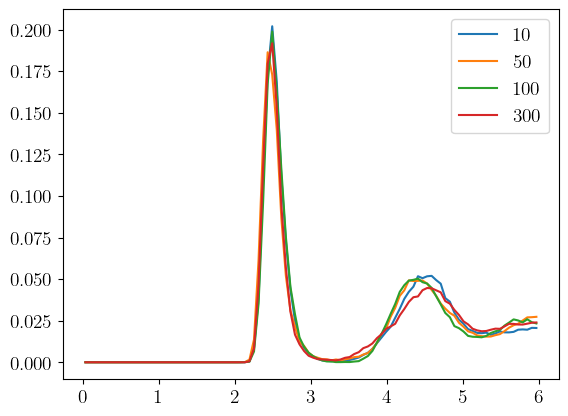

In [457]:
plt.plot(r_FT_10, rdf_FT_10, label = "10")
plt.plot(r_FT_50, rdf_FT_50, label = "50")
plt.plot(r_FT_100, rdf_FT_100, label = "100")
plt.plot(r_FT_300, rdf_FT_300, label = "300")
plt.legend()

In [273]:
def normalise_rdf(r, rdf, traj, o_indices):
    dr = r[1] - r[0]  # Bin width
    shell_volumes = 4.0 / 3.0 * np.pi * ((r + dr/2) ** 3 - (r - dr/2) ** 3)  # Shell volumes

    # Compute number density of j-atoms
    total_volume = traj[0].get_volume()  # Get simulation box volume
    number_density = len(o_indices) / total_volume  # Assuming j_indices are O atoms

    # Apply normalization
    rdf_corrected = rdf / (shell_volumes * number_density)
    return rdf_corrected

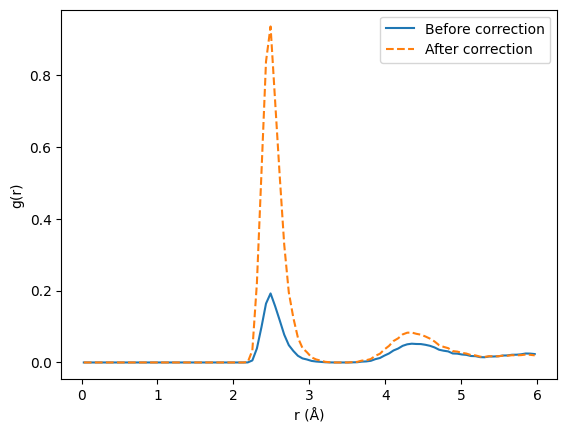

In [274]:
rdf_corrected_FT = normalise_rdf(r_FT, rdf_FT, traj_FT, o_indices_FT)

plt.figure()
plt.plot(r_FT, rdf_FT, label="Before correction")
plt.plot(r_FT, rdf_corrected_FT, label="After correction", linestyle="dashed")
plt.xlabel("r (Å)")
plt.ylabel("g(r)")
plt.legend()
plt.show()

In [671]:
#ca_co3_scratch = io.read("caco3_traj/CaCO3_scratch_120000.traj", index="2000:3000")
traj_scratch_300 = io.read("caco3_traj/CaCO3_modified_scratch_300_120000.traj", index="2000:5000")
traj_scratch_100 = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index="2000:5000")
traj_scratch_10 = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index="2000:5000")
traj_scratch_50 = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index="2000:5000")


In [312]:
ca_indices_scratch_10 = [atom.index for atom in traj_scratch_10[0] if atom.symbol == 'Ca']
o_indices_scratch_10 = [atom.index for atom in traj_scratch_10[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_10)} Ca atoms and {len(o_indices_scratch_10)} O atoms.")

# Compute RDF
r_scratch_10, rdf_scratch_10 = compute_rdf_optimized(traj_scratch_10, ca_indices_scratch_10, o_indices_scratch_10, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [377]:
ca_indices_scratch_50 = [atom.index for atom in traj_scratch_50[0] if atom.symbol == 'Ca']
o_indices_scratch_50 = [atom.index for atom in traj_scratch_50[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_50)} Ca atoms and {len(o_indices_scratch_50)} O atoms.")

# Compute RDF
r_scratch_50, rdf_scratch_50 = compute_rdf_optimized(traj_scratch_50, ca_indices_scratch_50, o_indices_scratch_50, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [313]:
ca_indices_scratch_100 = [atom.index for atom in traj_scratch_100[0] if atom.symbol == 'Ca']
o_indices_scratch_100 = [atom.index for atom in traj_scratch_100[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_100)} Ca atoms and {len(o_indices_scratch_100)} O atoms.")

# Compute RDF
r_scratch_100, rdf_scratch_100 = compute_rdf_optimized(traj_scratch_100, ca_indices_scratch_100, o_indices_scratch_100, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_scratch_200 = [atom.index for atom in traj_scratch_200[0] if atom.symbol == 'Ca']
o_indices_scratch_200 = [atom.index for atom in traj_scratch_200[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_200)} Ca atoms and {len(o_indices_scratch_200)} O atoms.")

# Compute RDF
r_scratch_200, rdf_scratch_200 = compute_rdf_optimized(traj_scratch_200, ca_indices_scratch_200, o_indices_scratch_200, r_max=6.0, bins=200)

In [672]:
ca_indices_scratch_300 = [atom.index for atom in traj_scratch_300[0] if atom.symbol == 'Ca']
o_indices_scratch_300 = [atom.index for atom in traj_scratch_300[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_300)} Ca atoms and {len(o_indices_scratch_300)} O atoms.")

# Compute RDF
r_scratch_300, rdf_scratch_300 = compute_rdf_optimized(traj_scratch_300, ca_indices_scratch_300, o_indices_scratch_300, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


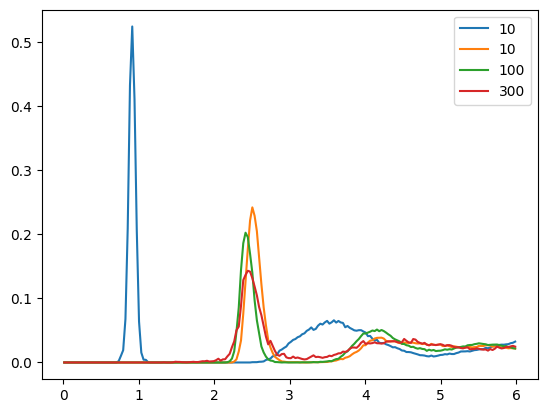

In [ ]:
plt.plot(r_scratch_10, rdf_scratch_10, label="10")
plt.plot(r_scratch_50, rdf_scratch_50, label="50")
plt.plot(r_scratch_100, rdf_scratch_100, label="100")
plt.plot(r_scratch_300, rdf_scratch_300, label="300")
plt.legend()

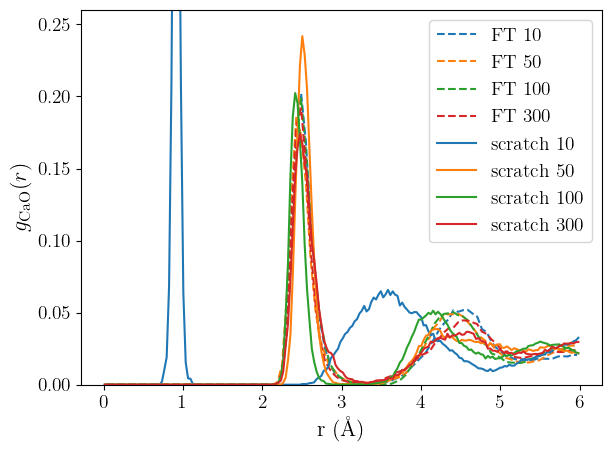

In [676]:
plt.Figure(figsize=(6,5))

plt.plot(r_FT_10, rdf_FT_10, linestyle = "--", label = "FT 10", color = 'C0')
plt.plot(r_FT_50, rdf_FT_50, linestyle = "--", label = "FT 50", color = 'C1')
plt.plot(r_FT_100, rdf_FT_100, linestyle = "--", label = "FT 100", color = 'C2')
plt.plot(r_FT_300, rdf_FT_300, linestyle = "--", label = "FT 300", color = 'C3')

plt.plot(r_scratch_10, rdf_scratch_10, label="scratch 10", color = 'C0')
plt.plot(r_scratch_50, rdf_scratch_50, label="scratch 50", color = 'C1')
plt.plot(r_scratch_100, rdf_scratch_100, label="scratch 100", color = 'C2')
plt.plot(r_scratch_300, rdf_scratch_300, label="scratch 300", color = 'C3')

plt.legend()
plt.xlabel(r'r ($\rm \AA$)')
plt.ylabel(r'$g_{\mathrm{\scriptstyle CaO}}(r)$')
plt.ylim(0,0.26)

plt.tight_layout()
plt.savefig('figures/g_r_ca.pdf')
plt.show()

In [93]:
import json
import matplotlib.pyplot as plt
import pandas as pd

with open("caco3_ref_data/rdf_caco3.json", 'r') as f:
    ref_rdf = json.load(f)
with open("caco3_ref_data/rdf_integral_caco3.json", 'r') as f:
    ref_rdf_integral = json.load(f)

values_x_rdf = [i['value'][0] for i in ref_rdf['datasetColl'][0]['data']]
values_y_rdf = [i['value'][1] for i in ref_rdf['datasetColl'][0]['data']]
sorted_indices = np.argsort(values_x_rdf)
values_x_rdf = np.array(values_x_rdf)[sorted_indices]
values_y_rdf = np.array(values_y_rdf)[sorted_indices]

values_x_rdf_integral = [i['value'][0] for i in ref_rdf_integral['datasetColl'][0]['data']]
values_y_rdf_integral = [i['value'][1] for i in ref_rdf_integral['datasetColl'][0]['data']]
sorted_indices = np.argsort(values_x_rdf_integral)
values_x_rdf_integral = np.array(values_x_rdf_integral)[sorted_indices]
values_y_rdf_integral = np.array(values_y_rdf_integral)[sorted_indices]

In [278]:
import numpy as np

def normalize_rdf(r, gr, ref_r, ref_gr):

    ref_integral = np.trapz(ref_gr, ref_r)
    # Compute integral of current RDF
    integral_g_r = np.trapz(gr, r)
    scale_factor = ref_integral / integral_g_r
    normalized_g_r = gr * scale_factor
    
    return normalized_g_r


In [ ]:
def compute_integrated_rdf(r, rdf, number_density):

    dr = r[1] - r[0]  # Bin width (assuming uniform bins)
    
    # Compute the cumulative sum (numerical integration using trapezoidal rule)
    integrated_rdf = 4 * np.pi * number_density * np.cumsum(rdf * r**2 * dr)
    
    return integrated_rdf

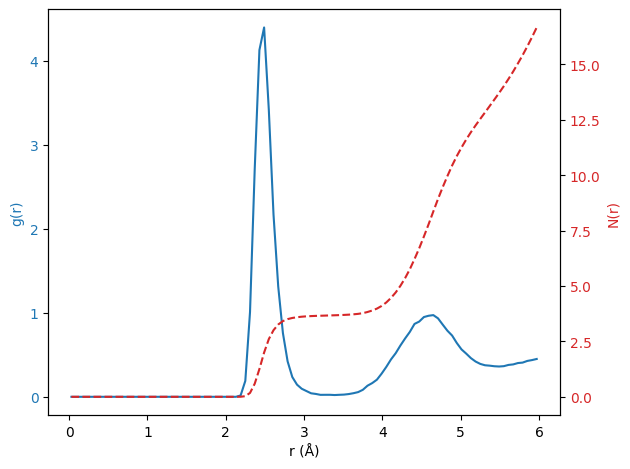

In [ ]:


# Compute number density
total_volume = first_frame.get_volume()
number_density = len(o_indices) / total_volume  # Assuming RDF is Ca-O

# Compute integrated RDF
integrated_rdf = compute_integrated_rdf(r, rdf_corrected, number_density)

# Plot RDF and Integrated RDF
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel("r (Å)")
ax1.set_ylabel("g(r)", color="tab:blue")
ax1.plot(r, rdf_corrected, color="tab:blue", label="RDF")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("N(r)", color="tab:red")
ax2.plot(r, integrated_rdf, color="tab:red", linestyle="dashed", label="Integrated RDF")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.tight_layout()
plt.show()


### RDF: O-O

In [234]:
with open("caco3_ref_data/rdf_oo_ref_caco3.json", 'r') as f:
    ref_rdf_oo = json.load(f)
with open("caco3_ref_data/rdf_oo_ref_exp_caco3.json", 'r') as f:
    ref_rdf_exp_oo = json.load(f)
    

values_x_rdf_oo = [i['value'][0] for i in ref_rdf_oo['datasetColl'][0]['data']]
values_y_rdf_oo = [i['value'][1] for i in ref_rdf_oo['datasetColl'][0]['data']]
sorted_indices = np.argsort(values_x_rdf_oo)
values_x_rdf_oo = np.array(values_x_rdf_oo)[sorted_indices]
values_y_rdf_oo = np.array(values_y_rdf_oo)[sorted_indices]

values_x_rdf_exp_oo = [i['value'][0] for i in ref_rdf_exp_oo['datasetColl'][0]['data']]
values_y_rdf_exp_oo = [i['value'][1] for i in ref_rdf_exp_oo['datasetColl'][0]['data']]
sorted_indices = np.argsort(values_x_rdf_exp_oo)
values_x_rdf_exp_oo = np.array(values_x_rdf_exp_oo)[sorted_indices]
values_y_rdf_exp_oo = np.array(values_y_rdf_exp_oo)[sorted_indices]

In [316]:
r_FT_10_oo, rdf_FT_10_oo = compute_rdf_optimized(traj_FT_10, o_indices_FT_10, o_indices_FT_10, r_max=6.0, bins=100)

In [380]:
r_FT_50_oo, rdf_FT_50_oo = compute_rdf_optimized(traj_FT_50, o_indices_FT_50, o_indices_FT_50, r_max=6.0, bins=100)

In [317]:
r_FT_100_oo, rdf_FT_100_oo = compute_rdf_optimized(traj_FT_100, o_indices_FT_100, o_indices_FT_100, r_max=6.0, bins=100)

In [318]:
r_FT_300_oo, rdf_FT_300_oo = compute_rdf_optimized(traj_FT_300, o_indices_FT_300, o_indices_FT_300, r_max=6.0, bins=100)

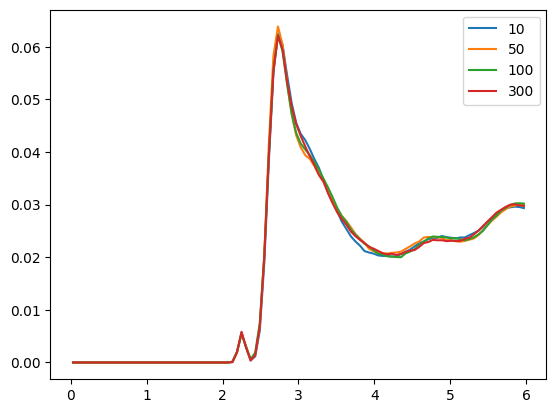

In [387]:
plt.plot(r_FT_10_oo, rdf_FT_10_oo, label = "10")
plt.plot(r_FT_50_oo, rdf_FT_50_oo, label = "50")
plt.plot(r_FT_100_oo, rdf_FT_100_oo, label = "100")
plt.plot(r_FT_300_oo, rdf_FT_300_oo, label = "300")
plt.legend()

In [320]:
r_scratch_10_oo, rdf_scratch_10_oo = compute_rdf_optimized(traj_scratch_10, o_indices_scratch_10, o_indices_scratch_10, r_max=6.0, bins=100)

In [381]:
r_scratch_50_oo, rdf_scratch_50_oo = compute_rdf_optimized(traj_scratch_50, o_indices_scratch_50, o_indices_scratch_50, r_max=6.0, bins=100)

In [321]:
r_scratch_100_oo, rdf_scratch_100_oo = compute_rdf_optimized(traj_scratch_100, o_indices_scratch_100, o_indices_scratch_100, r_max=6.0, bins=100)

In [674]:
r_scratch_300_oo, rdf_scratch_300_oo = compute_rdf_optimized(traj_scratch_300, o_indices_scratch_300, o_indices_scratch_300, r_max=6.0, bins=100)

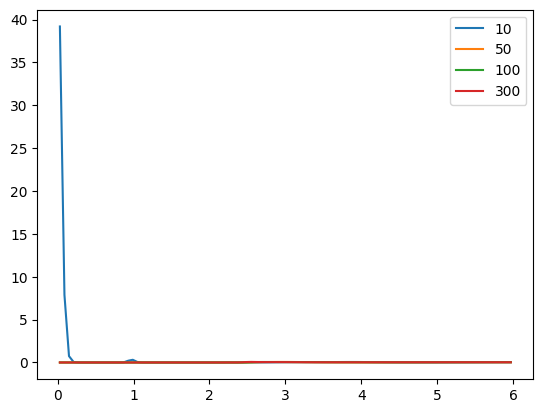

In [388]:
plt.plot(r_scratch_10_oo, rdf_scratch_10_oo, label = "10")
plt.plot(r_scratch_50_oo, rdf_scratch_50_oo, label = "50")
plt.plot(r_scratch_100_oo, rdf_scratch_100_oo, label = "100")
plt.plot(r_scratch_300_oo, rdf_scratch_300_oo, label = "300")
plt.legend()

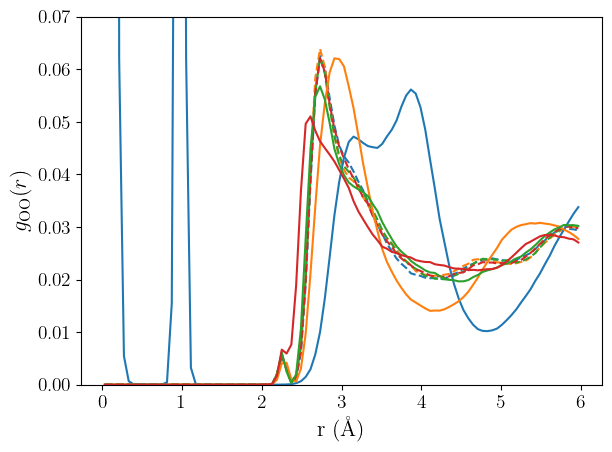

In [675]:
plt.Figure(figsize=(6,5))

plt.plot(r_FT_10_oo, rdf_FT_10_oo, linestyle = "--", label = "FT 10", color = 'C0')
plt.plot(r_FT_50_oo, rdf_FT_50_oo, linestyle = "--", label = "FT 50", color = 'C1')
plt.plot(r_FT_100_oo, rdf_FT_100_oo, linestyle = "--", label = "FT 100", color = 'C2')
plt.plot(r_FT_300_oo, rdf_FT_300_oo, linestyle = "--", label = "FT 300", color = 'C3')

plt.plot(r_scratch_10_oo, rdf_scratch_10_oo, label = "scratch 10", color = 'C0')
plt.plot(r_scratch_50_oo, rdf_scratch_50_oo, label = "scratch 50", color = 'C1')
plt.plot(r_scratch_100_oo, rdf_scratch_100_oo, label = "scratch 100", color = 'C2')
plt.plot(r_scratch_300_oo, rdf_scratch_300_oo, label = "scratch 300", color = 'C3')

plt.ylim(0,0.07)
plt.xlabel(r'r ($\rm \AA$)')
plt.ylabel(r'$g_{\mathrm{\scriptstyle OO}}(r)$')

plt.tight_layout()
#plt.savefig('figures/g_r_oo.pdf')
plt.show()

### MSD of oxygen

In [172]:
with open("caco3_ref_data/MSD_ref_caco3.json", 'r') as f:
    ref_msd = json.load(f)

values_x_msd = [i['value'][0] for i in ref_msd['datasetColl'][0]['data']]
values_y_msd = [i['value'][1] for i in ref_msd['datasetColl'][0]['data']]
sorted_indices = np.argsort(values_x_msd)
values_x_msd = np.array(values_x_msd)[sorted_indices]
values_y_msd = np.array(values_y_msd)[sorted_indices]

In [ ]:
def compute_msd(traj, atom_symbol="O"):

    oxygen_indices = [atom.index for atom in traj[0] if atom.symbol == atom_symbol]

    # Extract number of frames and number of oxygen atoms
    num_frames = len(traj)
    num_atoms = len(oxygen_indices)
    
    # Store initial positions
    initial_positions = traj[0].get_positions()[oxygen_indices]

    # Compute MSD
    msd_values = np.zeros(num_frames)

    for i, atoms in enumerate(traj):
        current_positions = atoms.get_positions()[oxygen_indices]
        displacements = current_positions - initial_positions
        squared_displacements = np.sum(displacements**2, axis=1)  # Sum over x, y, z
        msd_values[i] = np.mean(squared_displacements)  # Average over all oxygen atoms

    time_steps = np.arange(num_frames)  # Assuming equal time steps

    return time_steps/100, msd_values

In [336]:
traj_FT_10_MSD = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = "2000:")
traj_FT_50_MSD = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = "2000:")
traj_FT_100_MSD = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = "2000:")
traj_FT_300_MSD = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = "2000:")

traj_scratch_10_MSD = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index="2000:")
traj_scratch_50_MSD = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index="2000:")
traj_scratch_100_MSD = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index="2000:")
traj_scratch_300_MSD = io.read("caco3_traj/CaCO3_modified_scratch_120000.traj", index="2000:")


In [383]:
traj_FT_100_250000_MSD = io.read("caco3_traj/CaCO3_modified_FT_100_250000.traj", index = "2000:")

In [ ]:
time_FT_100_250000, avg_msd_FT_100_250000 = compute_msd(traj_FT_100_250000_MSD, atom_symbol="O")


In [ ]:
time_FT_10, avg_msd_FT_10 = compute_msd(traj_FT_10_MSD, atom_symbol="O")
time_FT_50, avg_msd_FT_50 = compute_msd(traj_FT_50_MSD, atom_symbol="O")
time_FT_100, avg_msd_FT_100 = compute_msd(traj_FT_100_MSD, atom_symbol="O")
time_FT_300, avg_msd_FT_300 = compute_msd(traj_FT_300_MSD, atom_symbol="O")

time_scratch_10, avg_msd_scratch_10 = compute_msd(traj_scratch_10_MSD, atom_symbol="O")
time_scratch_50, avg_msd_scratch_50 = compute_msd(traj_scratch_50_MSD, atom_symbol="O")
time_scratch_100, avg_msd_scratch_100 = compute_msd(traj_scratch_100_MSD, atom_symbol="O")
time_scratch_300, avg_msd_scratch_300 = compute_msd(traj_scratch_300_MSD, atom_symbol="O")



In [418]:
time_FT_10_Ca, avg_msd_FT_10_Ca = compute_msd(traj_FT_10_MSD, atom_symbol="Ca")
time_FT_50_Ca, avg_msd_FT_50_Ca = compute_msd(traj_FT_50_MSD, atom_symbol="Ca")
time_FT_100_Ca, avg_msd_FT_100_Ca = compute_msd(traj_FT_100_MSD, atom_symbol="Ca")
time_FT_300_Ca, avg_msd_FT_300_Ca = compute_msd(traj_FT_300_MSD, atom_symbol="Ca")

time_FT_100_250000_Ca, avg_msd_FT_100_250000_Ca = compute_msd(traj_FT_100_250000_MSD, atom_symbol="Ca")


time_scratch_10_Ca, avg_msd_scratch_10_Ca = compute_msd(traj_scratch_10_MSD, atom_symbol="Ca")
time_scratch_50_Ca, avg_msd_scratch_50_Ca = compute_msd(traj_scratch_50_MSD, atom_symbol="Ca")
time_scratch_100_Ca, avg_msd_scratch_100_Ca = compute_msd(traj_scratch_100_MSD, atom_symbol="Ca")
time_scratch_300_Ca, avg_msd_scratch_300_Ca = compute_msd(traj_scratch_300_MSD, atom_symbol="Ca")

In [679]:
time_FT_10

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.998e+01, 9.999e+01,
       1.000e+02])

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1849601223.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(time_FT_10), max(time_FT_10))


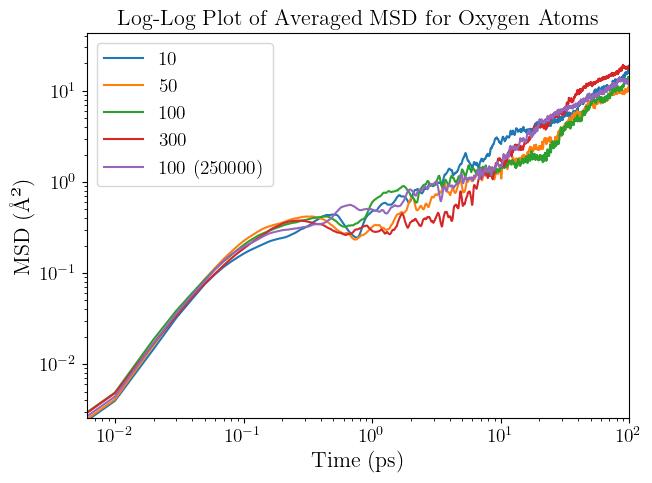

In [682]:
plt.figure(figsize=(7, 5))
plt.loglog(time_FT_10, avg_msd_FT_10, label="10")
plt.loglog(time_FT_50, avg_msd_FT_50, label="50")
plt.loglog(time_FT_100, avg_msd_FT_100, label="100")
plt.loglog(time_FT_300, avg_msd_FT_300, label="300")

plt.loglog(time_FT_100_250000, avg_msd_FT_100_250000, label="100 (250000)")



plt.xlabel("Time (ps)")
plt.ylabel("MSD (Å²)")
plt.title("Log-Log Plot of Averaged MSD for Oxygen Atoms")
plt.xlim(min(time_FT_10), max(time_FT_10))
plt.legend()
plt.show()

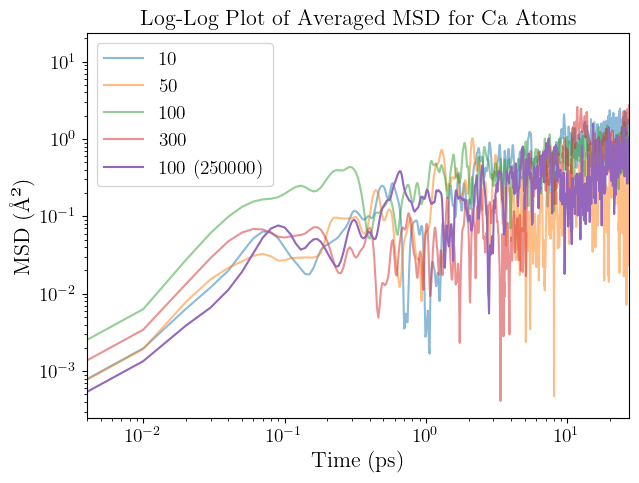

In [552]:
plt.figure(figsize=(7, 5))
plt.loglog(time_FT_10_Ca, avg_msd_FT_10_Ca, label="10", alpha = 0.5)
plt.loglog(time_FT_50_Ca, avg_msd_FT_50_Ca, label="50", alpha = 0.5)
plt.loglog(time_FT_100_Ca, avg_msd_FT_100_Ca, label="100", alpha = 0.5)
plt.loglog(time_FT_300_Ca, avg_msd_FT_300_Ca, label="300", alpha = 0.5)

plt.loglog(time_FT_100_250000_Ca, avg_msd_FT_100_250000_Ca, label="100 (250000)")



plt.xlabel("Time (ps)")
plt.ylabel("MSD (Å²)")
plt.title("Log-Log Plot of Averaged MSD for Ca Atoms")
plt.xlim(min(values_x_msd), max(values_x_msd))
plt.legend()
plt.show()

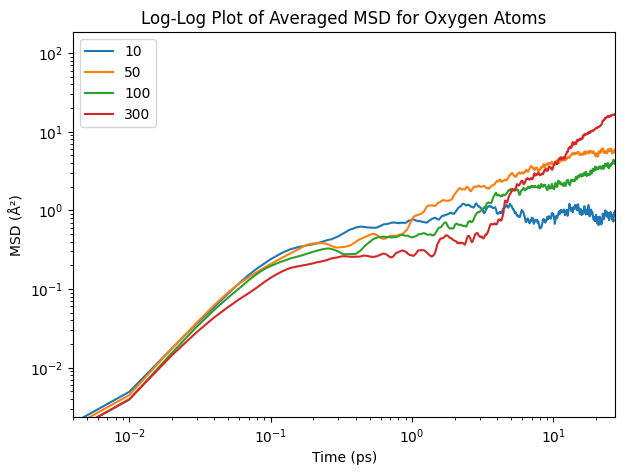

In [339]:
plt.figure(figsize=(7, 5))
plt.loglog(time_scratch_10, avg_msd_scratch_10, label="10")
plt.loglog(time_scratch_50, avg_msd_scratch_50, label="50")
plt.loglog(time_scratch_100, avg_msd_scratch_100, label="100")
plt.loglog(time_scratch_300, avg_msd_scratch_300, label="300")


plt.xlabel("Time (ps)")
plt.ylabel("MSD (Å²)")
plt.title("Log-Log Plot of Averaged MSD for Oxygen Atoms")
plt.xlim(min(values_x_msd), max(values_x_msd))
plt.legend()
plt.show()

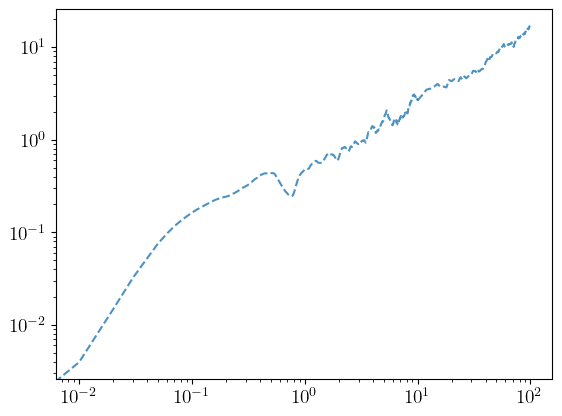

In [700]:
idx = np.where(time_FT_10 > 10)[0][0]
plt.loglog(time_FT_10[:idx], avg_msd_FT_10[:idx], linestyle="--", label="FT 10 (all points)", color='C0', alpha=0.8)

plt.loglog(time_FT_10[idx::100], avg_msd_FT_10[idx::100], linestyle="--", color='C0', alpha=0.8)


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3568433629.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(time_FT_10), max(time_FT_10))
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3568433629.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100)


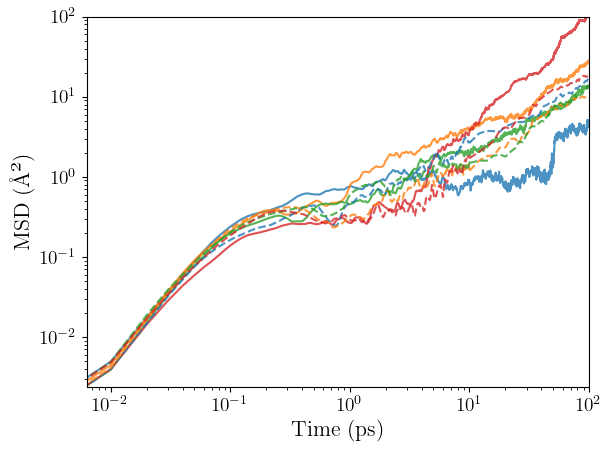

In [706]:
plt.Figure(figsize=(6,5))

# plt.loglog(time_FT_10, avg_msd_FT_10,  linestyle="--", label="FT 10", color = 'C0', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_50, avg_msd_FT_50, linestyle = "--", label="FT 50", color = 'C1', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_100, avg_msd_FT_100, linestyle = "--", label="FT 100", color = 'C2', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_300, avg_msd_FT_300, linestyle = "--", label="FT 300", color = 'C3', alpha = 0.8, zorder = 2)


datasets = {
    "FT 10": ("C0", time_FT_10, avg_msd_FT_10),
    "FT 50": ("C1", time_FT_50, avg_msd_FT_50),
    "FT 100": ("C2", time_FT_100, avg_msd_FT_100),
    "FT 300": ("C3", time_FT_300, avg_msd_FT_300),
}

for label, (color, time_data, msd_data) in datasets.items():
    x_values = np.array(time_data)
    y_values = np.array(msd_data)

    # Find index where x > 10
    idx = np.where(x_values > 10)[0][0] if np.any(x_values > 10) else len(x_values)

    # Plot all points up to x = 10
    plt.loglog(x_values[:idx], y_values[:idx], linestyle="--", label=f"{label} (all points)", color=color, alpha=0.8, zorder=2)

    # Plot every 10th point after x = 10
    plt.loglog(x_values[idx::200], y_values[idx::200], linestyle="--", color=color, alpha=0.8, zorder=2)




plt.loglog(time_scratch_10, avg_msd_scratch_10, label="scratch 10", color = 'C0', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_50, avg_msd_scratch_50, label="scratch 50", color = 'C1', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_100, avg_msd_scratch_100, label="scratch 100", color = 'C2', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_300, avg_msd_scratch_300, label="scratch 300", color = 'C3', alpha = 0.8, zorder=1)


plt.xlabel("Time (ps)")
plt.xlim(min(time_FT_10), max(time_FT_10))

plt.ylabel("MSD (Å²)")
plt.xlabel("Time (ps)")
plt.ylim(0,100)

plt.tight_layout()
plt.savefig('figures/MSD_O.pdf')
plt.show()

plt.show()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3771138233.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,25)


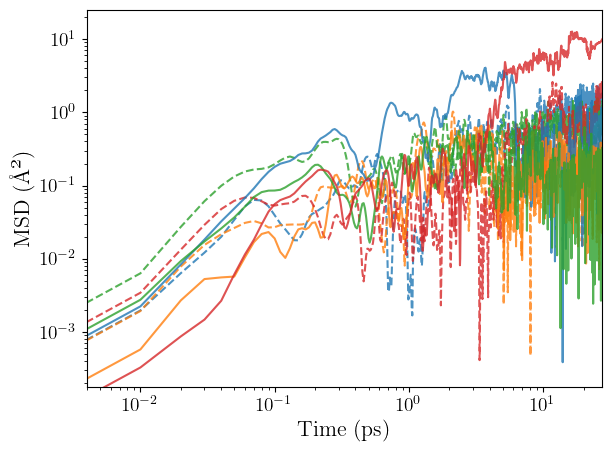

In [440]:
plt.Figure(figsize=(6,5))

plt.loglog(time_FT_10_Ca, avg_msd_FT_10_Ca, linestyle = "--", label="FT 10", color = 'C0', alpha = 0.8)
plt.loglog(time_FT_50_Ca, avg_msd_FT_50_Ca, linestyle = "--", label="FT 50", color = 'C1', alpha = 0.8)
plt.loglog(time_FT_100_Ca, avg_msd_FT_100_Ca, linestyle = "--", label="FT 100", color = 'C2', alpha = 0.8)
plt.loglog(time_FT_300_Ca, avg_msd_FT_300_Ca, linestyle = "--", label="FT 300", color = 'C3', alpha = 0.8)

plt.loglog(time_scratch_10_Ca, avg_msd_scratch_10_Ca, label="scratch 10", color = 'C0', alpha = 0.8)
plt.loglog(time_scratch_50_Ca, avg_msd_scratch_50_Ca, label="scratch 50", color = 'C1', alpha = 0.8)
plt.loglog(time_scratch_100_Ca, avg_msd_scratch_100_Ca, label="scratch 100", color = 'C2', alpha = 0.8)
plt.loglog(time_scratch_300_Ca, avg_msd_scratch_300_Ca, label="scratch 300", color = 'C3', alpha = 0.8)



plt.xlabel("Time (ps)")
plt.xlim(min(values_x_msd), max(values_x_msd))
#plt.legend()
plt.ylabel("MSD (Å²)")
plt.xlabel("Time (ps)")
plt.ylim(0,25)

plt.tight_layout()
plt.savefig('figures/MSD_Ca.pdf')
plt.show()

plt.show()

### Coordination

- can get free energy by inverting the probability density of beign in each coordination number using - kbT ln(rho)

In [340]:
def compute_CN(R_t, r_CaO_min_1, n, m):
    CN_t = np.sum(
        (1 - (R_t / r_CaO_min_1)**n) / (1 - (R_t / r_CaO_min_1)**m),
        axis=1
    )
    return CN_t

In [556]:
traj_FT_100_250000 = io.read("caco3_traj/CaCO3_modified_FT_100_250000.traj", index = ":")
traj_FT_100_600k_250000 = io.read("caco3_traj/CaCO3_modified_FT_100_600K_250000.traj", index = ":")

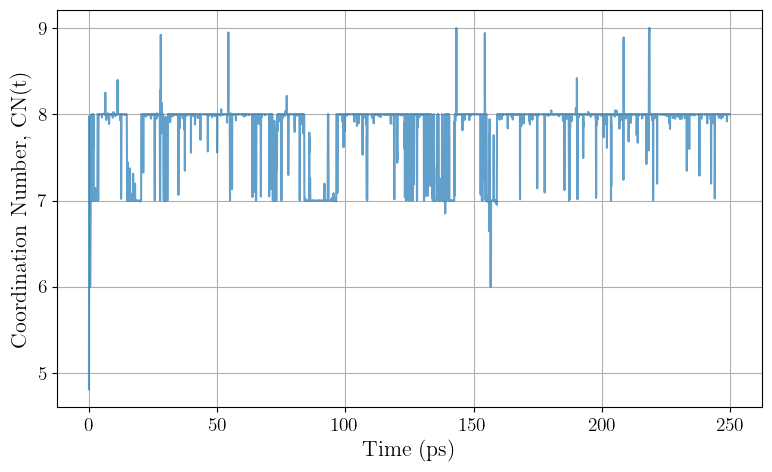

In [561]:
n = 60
m = 200
r_CaO_min_1 = 3.25

# Function to compute pairwise Ca-O distances in each frame
def get_CaO_distances(atoms):
    Ca_indices = [atom.index for atom in atoms if atom.symbol == "Ca"]
    O_indices = [atom.index for atom in atoms if atom.symbol == "O"]

    distances = []
    for ca in Ca_indices:
        for o in O_indices:
            d = atoms.get_distance(ca, o, mic=True)  # Minimum image convention
            distances.append(d)
    return np.array(distances)

# Compute CN for each frame in trajectory
CN_values = []
for atoms in traj_FT_100_250000:
    R_t = get_CaO_distances(atoms)  # Get distances at this timestep
    CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
    CN_values.append(CN_t)

# Convert to numpy array for analysis
CN_values = np.array(CN_values)

plt.Figure(figsize=(6,5))

# Plot CN evolution over time
plt.figure(figsize=(8, 5))
plt.plot(np.array(range(len(CN_values[CN_values>4.5]))) / 100, CN_values[CN_values>4.5], linestyle="-", alpha=0.7)
plt.xlabel("Time (ps)")
plt.ylabel("Coordination Number, CN(t)")
#plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/CN_time.pdf')
plt.show()


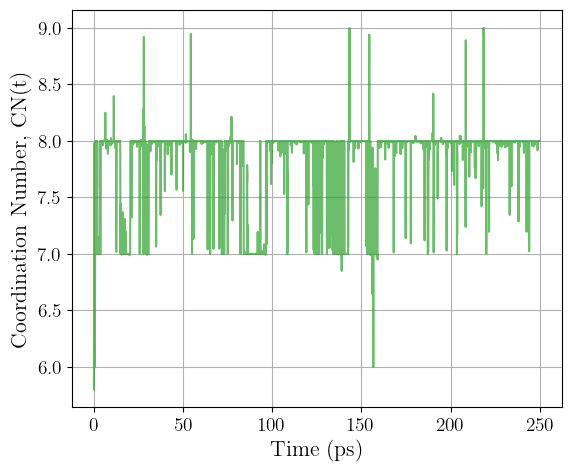

In [476]:
plt.figure(figsize=(6,5))


plt.plot(np.array(range(len(CN_values[CN_values>5.7]))) / 100, CN_values[CN_values>5.7], linestyle="-", alpha=0.7, color = "C2")
plt.xlabel("Time (ps)")
plt.ylabel("Coordination Number, CN(t)")
#plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/CN_time.pdf')
plt.show()

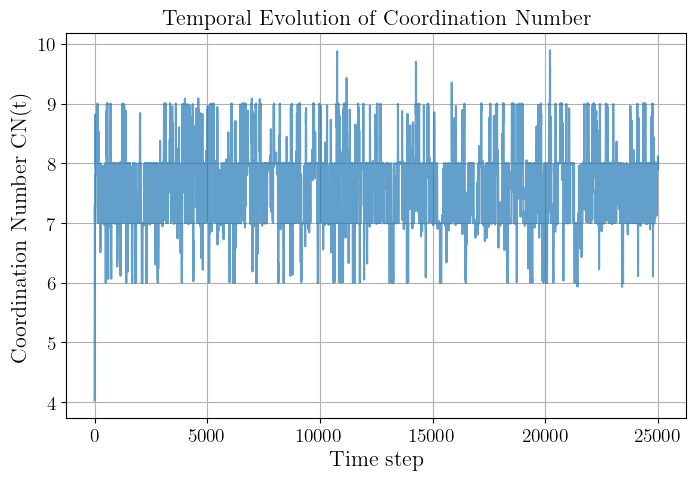

In [557]:
CN_values_600k = []
for atoms in traj_FT_100_600k_250000:
    R_t = get_CaO_distances(atoms)  # Get distances at this timestep
    CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
    CN_values_600k.append(CN_t)

CN_values_600k = np.array(CN_values_600k)

# Plot CN evolution over time
plt.figure(figsize=(8, 5))
plt.plot(range(len(CN_values_600k)), CN_values_600k, linestyle="-", alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Coordination Number CN(t)")
plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.show()

In [624]:
CN_values_FT["100"][CN_values_FT["100"]>5.7]

array([5.85308878, 5.96092657, 6.11973948, ..., 7.99996586, 7.99988246,
       7.99969767])

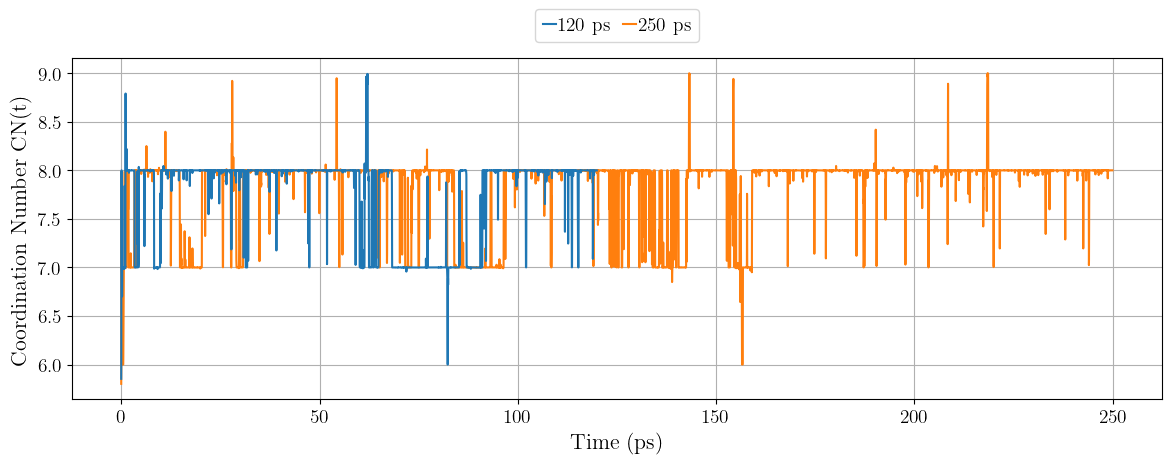

In [669]:
plt.figure(figsize=(12,5))


plt.plot(np.array(range(len(CN_values_FT["100"][CN_values_FT["100"]>5.7])))/100, CN_values_FT["100"][CN_values_FT["100"]>5.7], linestyle="-", alpha=1, color="C0", zorder=3, label = "120 ps")
plt.plot(np.array(range(len(CN_values[CN_values>5.7]))) / 100, CN_values[CN_values>5.7], linestyle="-", alpha=1, color="C1", zorder=2, label = "250 ps")
#plt.plot(np.array(range(len(CN_values_600k[CN_values_600k>5.7])))/100, CN_values_600k[CN_values_600k>5.7], linestyle="-", alpha=1, color="C2", zorder=1, label = "600 K (250 ps)")

plt.xlabel("Time (ps)", fontsize=16)
plt.ylabel("Coordination Number CN(t)", fontsize=16)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.17), columnspacing=0.6, handletextpad=0.1, handlelength=0.7, fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/CN_time_300_600.pdf")
plt.show()

In [422]:
Boltzmann

1.380649e-23

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1968053997.py:13: RuntimeWarning: divide by zero encountered in log
  free_energy = -kB * T * np.log(hist) # J per molecules
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1968053997.py:19: RuntimeWarning: divide by zero encountered in log
  free_energy_600k = -kB * T * np.log(hist_600k) * (6.03e23) / 1000


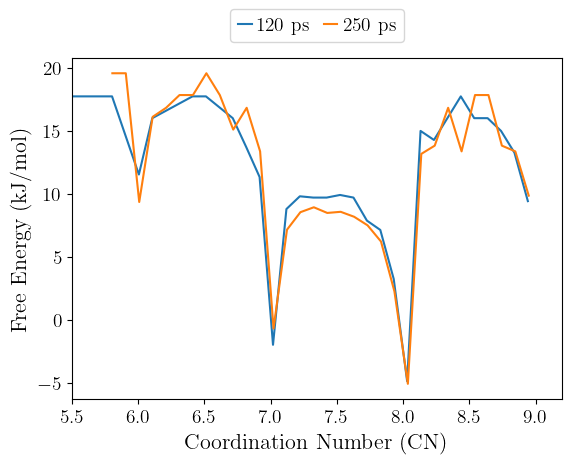

In [670]:
from scipy.constants import Boltzmann


T = 300  # Example: Temperature in Kelvin
kB = Boltzmann #8.617333e10-5 # eV/K 


bins = np.linspace(min(CN_values), max(CN_values), 50)  # Define histogram bins
hist, bin_edges = np.histogram(CN_values, bins=bins, density=True)  # Normalized probability density
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Compute free energy using F = -k_B T ln(p)
free_energy = -kB * T * np.log(hist) # J per molecules
free_energy = free_energy * (6.03e23) / 1000 # KJ/mol

bins_600k = np.linspace(min(CN_values_600k), max(CN_values_600k), 50)  # Define histogram bins
hist_600k, bin_edges_600k = np.histogram(CN_values_600k, bins=bins_600k, density=True)  # Normalized probability density
bin_centers_600k = (bin_edges_600k[:-1] + bin_edges_600k[1:]) / 2  # Compute bin centers
free_energy_600k = -kB * T * np.log(hist_600k) * (6.03e23) / 1000 


plt.figure(figsize=(6,5))

# Plot Free Energy Profile
plt.plot(bin_centres_FT["100"][valid_indices_FT["100"]], free_energy_FT["100"][valid_indices_FT["100"]], linestyle="-", alpha=1, label = "120 ps", color='C0')
plt.plot(bin_centers, free_energy, linestyle="-", alpha=1, label = '250 ps', color = "C1")
#plt.plot(bin_centers_600k, free_energy_600k, linestyle="-", alpha=1, label = '600 K (250 ps)', color = "C2")
plt.xlabel("Coordination Number (CN)", fontsize=16)
plt.ylabel("Free Energy (kJ/mol)", fontsize=16)
#plt.grid(True)
plt.xlim(5.5,9.2)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.17), columnspacing=0.7, handletextpad=0.3, handlelength=0.7, fontsize=14)
plt.tight_layout()
plt.savefig('figures/CN_free_energy_300_600.pdf')
plt.show()


using 100 ps

In [567]:
traj_FT_10_all = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = ":")
traj_FT_50_all = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = ":")
traj_FT_100_all = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = ":")
traj_FT_300_all = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = ":")

traj_scratch_10_all = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index=":")
traj_scratch_50_all = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index=":")
traj_scratch_100_all = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index=":")
#traj_scratch_300_all = io.read("caco3_traj/CaCO3_modified_scratch_120000.traj", index=":")
traj_scratch_300_all = io.read("caco3_traj/CaCO3_modified_scratch_300_120000.traj", index=":8000")


In [ ]:
plt.figure(figsize=(8, 5))

FT = {"10": traj_FT_10_all, "50": traj_FT_50_all, "100": traj_FT_100_all, "300": traj_FT_300_all}

CN_values_FT = {"10": [], "50": [], "100": [], "300": []}


for key, traj in zip(FT.keys(), list(FT.values())):
    for atoms in traj:
        R_t = get_CaO_distances(atoms)  # Get distances at this timestep
        CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
        CN_values_FT[key].append(CN_t)

    # Convert to numpy array for analysis
    CN_values_FT[key] = np.array(CN_values_FT[key])


<Figure size 800x500 with 0 Axes>

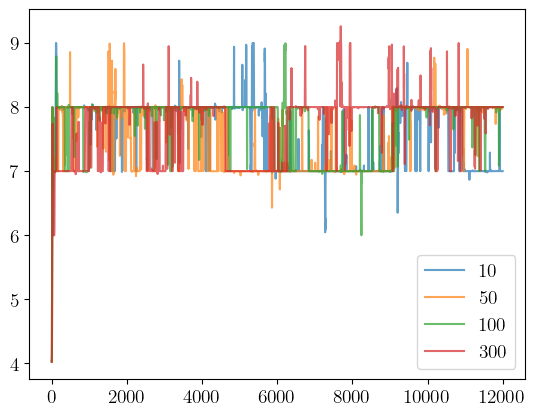

In [543]:
for key, CN_list in zip(CN_values_FT.keys(), list(CN_values_FT.values())):
    plt.plot(range(len(CN_list)), CN_list, linestyle="-", alpha=0.7, label = key)

plt.legend()

In [568]:
scratch = {"10": traj_scratch_10_all, "50": traj_scratch_50_all, "100": traj_scratch_100_all, "300": traj_scratch_300_all}
CN_values_scratch = {"10": [], "50": [], "100": [], "300": []}


for key, traj in zip(scratch.keys(), list(scratch.values())):
    for atoms in traj:
        R_t = get_CaO_distances(atoms)  # Get distances at this timestep
        CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
        CN_values_scratch[key].append(CN_t)

    # Convert to numpy array for analysis
    CN_values_scratch[key] = np.array(CN_values_scratch[key])


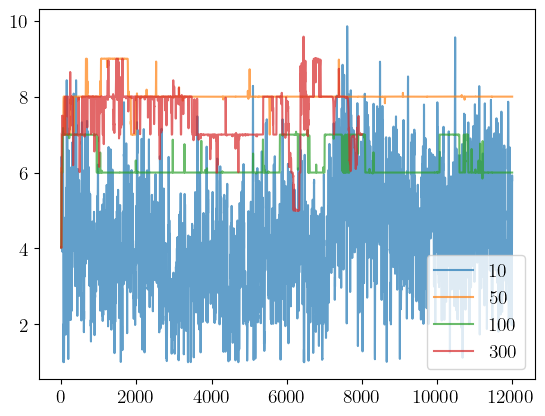

In [569]:
for key, CN_list in zip(CN_values_scratch.keys(), list(CN_values_scratch.values())):
    plt.plot(range(len(CN_list)), CN_list, linestyle="-", alpha=0.7, label = key)

plt.legend()

In [577]:
T = 300  # Example: Temperature in Kelvin
kB = Boltzmann #8.617333e10-5 # eV/K 

free_energy_FT = {"10": [], "50": [], "100": [], "300": []}
bin_centres_FT = {"10": [], "50": [], "100": [], "300": []}
valid_indices_FT = {"10": [], "50": [], "100": [], "300": []}

free_energy_scratch = {"10": [], "50": [], "100": [], "300": []}
bin_centres_scratch = {"10": [], "50": [], "100": [], "300": []}
valid_indices_scratch = {"10": [], "50": [], "100": [], "300": []}


for key, CN_list in zip(CN_values_FT.keys(), list(CN_values_FT.values())):

    bins = np.linspace(min(CN_list), max(CN_list), 50)  # Define histogram bins
    hist, bin_edges = np.histogram(CN_list, bins=bins, density=True)  # Normalized probability density
    bin_centres_FT[key] = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Compute free energy using F = -k_B T ln(p)
    free_energy_FT[key] = -kB * T * np.log(hist) # J per molecules
    free_energy_FT[key] = np.array(free_energy_FT[key]) * (6.03e23) / 1000 # KJ/mol
    valid_indices_FT[key] = np.isfinite(free_energy_FT[key])

for key, CN_list in zip(CN_values_scratch.keys(), list(CN_values_scratch.values())):

    bins = np.linspace(min(CN_list), max(CN_list), 50)  # Define histogram bins
    hist, bin_edges = np.histogram(CN_list, bins=bins, density=True)  # Normalized probability density
    bin_centres_scratch[key] = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Compute free energy using F = -k_B T ln(p)
    free_energy_scratch[key] = -kB * T * np.log(hist) # J per molecules
    free_energy_scratch[key] = np.array(free_energy_scratch[key]) * (6.03e23) / 1000 # KJ/mol
    valid_indices_scratch[key] = np.isfinite(free_energy_scratch[key])


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1506960464.py:20: RuntimeWarning: divide by zero encountered in log
  free_energy_FT[key] = -kB * T * np.log(hist) # J per molecules
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1506960464.py:31: RuntimeWarning: divide by zero encountered in log
  free_energy_scratch[key] = -kB * T * np.log(hist) # J per molecules


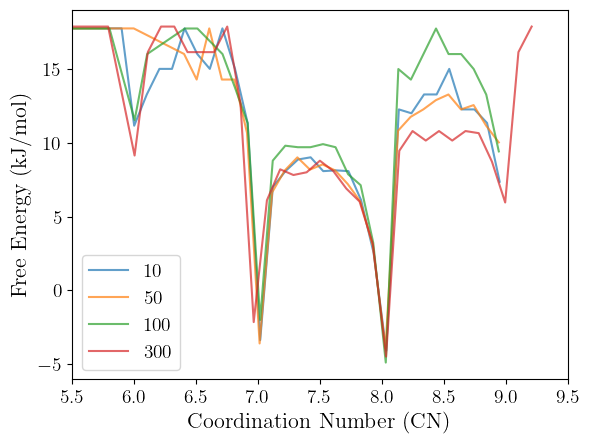

In [578]:
for key, free_energy, bin_centre in zip(free_energy_FT.keys(), list(free_energy_FT.values()), list(bin_centres_FT.values())):

    plt.plot(bin_centre[valid_indices_FT[key]], free_energy[valid_indices_FT[key]], linestyle="-", alpha=0.7, label = key)
    plt.xlabel("Coordination Number (CN)")
    plt.ylabel("Free Energy (kJ/mol)")
    plt.xlim(5.5,9.5)

plt.legend()



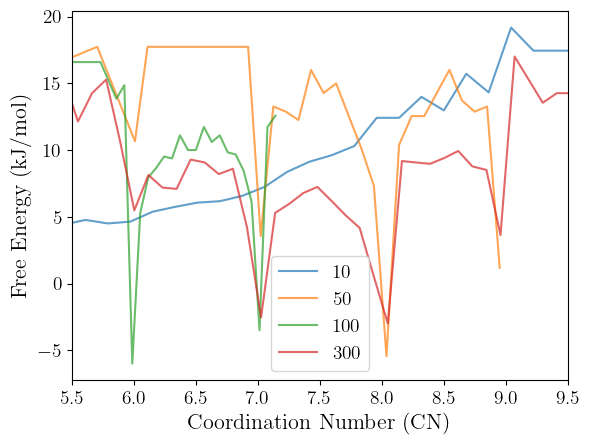

In [579]:
for key, free_energy, bin_centre in zip(free_energy_scratch.keys(), list(free_energy_scratch.values()), list(bin_centres_scratch.values())):

    plt.plot(bin_centre[valid_indices_scratch[key]], free_energy[valid_indices_scratch[key]], linestyle="-", alpha=0.7, label = key)
    plt.xlabel("Coordination Number (CN)")
    plt.ylabel("Free Energy (kJ/mol)")
    plt.xlim(5.5,9.5)

plt.legend()

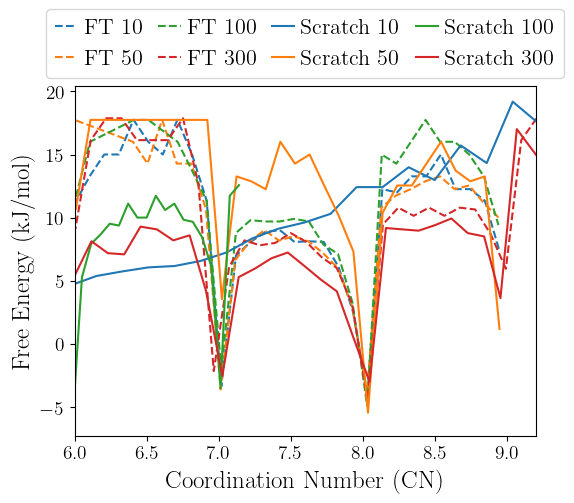

In [648]:
plt.figure(figsize=(6,5.5))

i = 0
for key, free_energy, bin_centre in zip(free_energy_FT.keys(), list(free_energy_FT.values()), list(bin_centres_FT.values())):

    plt.plot(bin_centre[valid_indices_FT[key]], free_energy[valid_indices_FT[key]], linestyle="--", alpha=1, label = f"FT {key}", color = f"C{i}")
    i+=1

i = 0
for key, free_energy, bin_centre in zip(free_energy_scratch.keys(), list(free_energy_scratch.values()), list(bin_centres_scratch.values())):

    plt.plot(bin_centre[valid_indices_scratch[key]], free_energy[valid_indices_scratch[key]], linestyle="-", alpha=1, label = f"Scratch {key}", color = f"C{i}")
    i+=1

plt.xlabel("Coordination Number (CN)", fontsize=18)
plt.ylabel("Free Energy (kJ/mol)", fontsize=18)
plt.xlim(6,9.2)
#plt.legend()
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), columnspacing=0.7, handletextpad=0.3, handlelength=1, fontsize=16)
plt.tight_layout()
plt.savefig('figures/CN_free_energy_all.pdf')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import windows, convolve
from scipy.ndimage import gaussian_filter1d

def compute_vdos_smooth(traj, atom_symbol="O", dt=1.0, sigma=10):

    atom_indices = [atom.index for atom in traj[0] if atom.symbol == atom_symbol]
    num_frames = len(traj)
    
    # Extract velocities for the selected atoms and compute VACF
    velocities = np.array([traj[i].get_velocities()[atom_indices] for i in range(num_frames)])
    vacf = np.zeros(num_frames)
    
    for i in range(num_frames):
        vacf[i] = np.mean(np.sum(velocities[0] * velocities[i], axis=1))  # Average over all atoms

    # Apply Hann window to smooth VACF
    vacf *= windows.hann(num_frames)

    # Compute Fourier Transform of VACF
    vdos_fft = np.abs(fft(vacf))
    frequencies = fftfreq(num_frames, dt) * 1e3  # Convert to THz

    # Convert frequency to cm⁻¹
    frequencies_cm1 = frequencies / 0.0299792

    # Apply Gaussian smoothing
    smoothed_vdos = gaussian_filter1d(vdos_fft, sigma=sigma)

    # Return only positive frequencies
    positive_indices = frequencies_cm1 >= 0

    return frequencies_cm1[positive_indices], smoothed_vdos[positive_indices]

def plot_vdos_smooth(frequencies, vdos, atom_labels=["O", "H", "F"], reference_data=None):
    """
    Plots the smoothed VDOS for multiple atom types in subplots.
    """
    fig, axes = plt.subplots(len(atom_labels), 1, figsize=(6, 9), sharex=True)

    for i, atom in enumerate(atom_labels):
        ax = axes[i]

        # Normalize VDOS
        vdos_norm = vdos[i] / np.max(vdos[i])

        # Plot Reference
        if reference_data is not None:
            ax.plot(reference_data[i][0], reference_data[i][1], 'k-', label="Reference", linewidth=1.2)

        # Plot MLP (Dotted Red Line)
        ax.plot(frequencies, vdos_norm, 'r--', label="MLP", linewidth=1.2)

        ax.set_ylabel("VDOS [a.u.]")
        ax.text(0.02, 0.85, atom, transform=ax.transAxes, fontsize=12, fontweight='bold')

        #ax.set_xlim(0, 4000)
        ax.grid(True, linestyle="--", alpha=0.5)

    axes[-1].set_xlabel("Freq. [1/cm]")
    axes[-1].legend(loc="best")

    plt.tight_layout()
    plt.show()


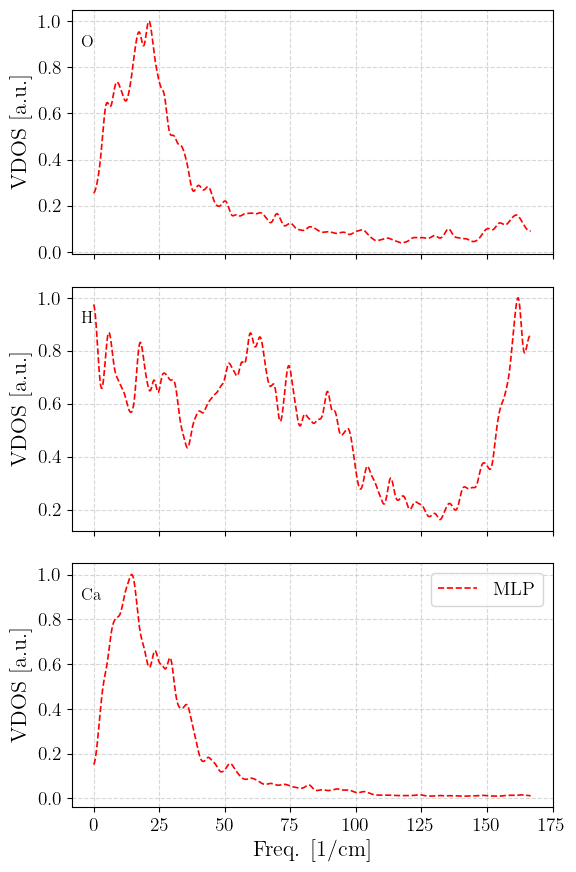

In [502]:
# Assume `traj` is your ASE trajectory

atom_types = ["O", "H", "Ca"]
vdos_data = [compute_vdos_smooth(traj_FT_100, atom, dt=100) for atom in atom_types]

# If you have reference VDOS data in the format [(freq, vdos), (freq, vdos), ...]
reference_data = None  # Replace with actual reference data if available

# Plot VDOS
plot_vdos_smooth(vdos_data[0][0], [vdos[1] for vdos in vdos_data], atom_types, reference_data)


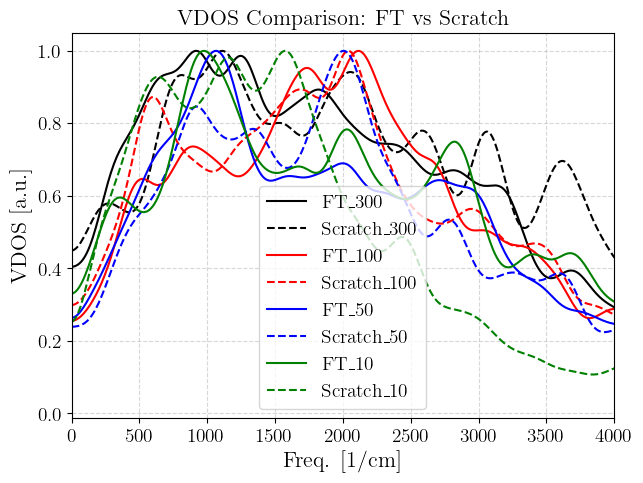

In [504]:


# Load Trajectories
ft_trajs = {
    "FT_300": io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index="2000:5000"),
    "FT_100": io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index="2000:5000"),
    "FT_50":  io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index="2000:5000"),
    "FT_10":  io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index="2000:5000"),
}

scratch_trajs = {
    "Scratch_300": io.read("caco3_traj/CaCO3_modified_scratch_120000.traj", index="2000:5000"),
    "Scratch_100": io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index="2000:5000"),
    "Scratch_50":  io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index="2000:5000"),
    "Scratch_10":  io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index="2000:5000"),
}

# Compute VDOS for each trajectory
vdos_data_ft = {label: compute_vdos_smooth(traj, atom_symbol="O", dt=1.0, sigma=10) for label, traj in ft_trajs.items()}
vdos_data_scratch = {label: compute_vdos_smooth(traj, atom_symbol="O", dt=1.0, sigma=10) for label, traj in scratch_trajs.items()}

# Plot Overlayed VDOS for FT and Scratch
plt.figure(figsize=(7, 5))

colors = ["black", "red", "blue", "green"]
line_styles = {"FT": "-", "Scratch": "--"}  # Solid for FT, Dashed for Scratch

for (label_ft, (freqs_ft, vdos_ft)), (label_scratch, (freqs_scratch, vdos_scratch)), color in zip(vdos_data_ft.items(), vdos_data_scratch.items(), colors):
    # Normalize VDOS
    vdos_ft /= np.max(vdos_ft)
    vdos_scratch /= np.max(vdos_scratch)

    # Plot FT (Solid Line)
    plt.plot(freqs_ft, vdos_ft, label=label_ft, color=color, linestyle="-", linewidth=1.5)
    
    # Plot Scratch (Dashed Line)
    plt.plot(freqs_scratch, vdos_scratch, label=label_scratch, color=color, linestyle="--", linewidth=1.5)

plt.xlabel("Freq. [1/cm]")
plt.ylabel("VDOS [a.u.]")
plt.xlim(0, 4000)  # Limit to relevant frequency range
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.title("VDOS Comparison: FT vs Scratch")

plt.show()
